In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import leidenalg as la
import numpy as np
import igraph as ig
import random
# the following two functions aim at drawing the hull of clusters.
from scipy import interpolate
from scipy.spatial import ConvexHull
from hulls import ConcaveHull

from datashader.bundling import hammer_bundle  # key for bundling
from scipy.stats import gaussian_kde

import geopandas as gpd
from pyproj import CRS

import requests
import json
import re
import difflib
import ast # polyname_column in allbuslines is a string like: '[x,y].[x,y], ...'
from shapely.geometry import LineString
import contextily as ctx
import coordTransform_utils as ctf

# make the texts in figures editable
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
                 }
matplotlib.rcParams.update(new_rc_params)

### 1. Visulization for Mumdord3 network

#### 1.1 Data Preparation

In [2]:
df_od = pd.read_csv('./data/OD_flow_duration_f.csv')
df_nodes = pd.read_csv('./data/mumford3_nodes.txt')
df_links = pd.read_csv('./data/mumford3_links.txt')
df_demand = pd.read_csv('./data/mumford3_demand.txt')

In [3]:
df_demand_merged = pd.merge(df_demand, df_nodes[['id','lat','lon']], how='inner',left_on='from',right_on='id')
df_demand_merged = pd.merge(df_demand_merged, df_nodes[['id','lat','lon']], how='inner',left_on='to',right_on='id')

##### 1.1.1 Convert df_demand of the Mumford3 network into the format of the df_od of Nanjing

In [4]:
df_demand_merged = df_demand_merged[['from', 'to', 'demand', 'lat_x', 'lon_x', 'lat_y', 'lon_y']].rename(
    columns={'from': 'o_station_name', 'to': 'd_station_name', 'demand': 'flow', 'lat_x': 'o_lat', 'lon_x': 'o_long',
             'lat_y': 'd_lat', 'lon_y': 'd_long'})

##### 1.1.2 Graph clustering on Mumford3 passenger flow network

In [5]:
def to_undirected_sum(G, weight='flow'):
    """
    convert directed graph to the undirected and sum the attribute,
    nx.to_undirected function only use the edge attribute with the max value
    """
    UG = G.to_undirected()
    for node in G:
        for ngbr in nx.neighbors(G, node):
            if node in nx.neighbors(G, ngbr):
                UG.edges[node, ngbr][weight] = (
                        G.edges[node, ngbr][weight] + G.edges[ngbr, node][weight]
                )
    return UG


def graph_clustering(G, level):
    coms_leiden_igraph = la.find_partition(ig.Graph.from_networkx(G),
                                           partition_type=la.ModularityVertexPartition,
                                           weights='flow', n_iterations=20, max_comm_size=60)
    print(coms_leiden_igraph.modularity)
    coms_leiden_df = pd.DataFrame()
    coms_leiden_df['station_name'] = np.array(G.nodes())
    coms_leiden_df['membership'] = coms_leiden_igraph.membership

    coms_leiden = coms_leiden_df.groupby('membership')['station_name'].apply(list).reset_index(name='community')
    coms_leiden['stop_num'] = coms_leiden.apply(lambda x: len(x['community']), axis=1)
    coms_leiden['level'] = level
    return coms_leiden

def unaddressed_flow(coms_ls, df):
    coms_df = [df[df.o_station_name.isin(each_com) & df.d_station_name.isin(each_com)] for each_com in
               coms_ls.community]
    if len(coms_df) > 0:
        od_flow_index = np.concatenate([each_com_df.index.values for each_com_df in coms_df], axis=0)
    else:
        return pd.DataFrame().reindex_like(df), coms_df

    return df[~df.index.isin(od_flow_index)], coms_df

def multi_leiden(df_od):

    total_flow = df_od.flow.sum()
    coms_ls = []
    df_exclude_ls = []
    # passenger flow network at each level of clustering
    df_each_level_ls = []

    level = 0

    while (df_od.flow.sum() / total_flow) > 0.001:
        df_each_level_ls.append(df_od)
        H = nx.from_pandas_edgelist(df_od, 'o_station_name', 'd_station_name', edge_attr=['flow'],
                                    create_using=nx.DiGraph())

        H_undirected = to_undirected_sum(H)

        coms_leiden = graph_clustering(H_undirected, level)

        coms_leiden = coms_leiden[coms_leiden.community.map(len) >= 12]

        coms_ls.append(coms_leiden)

        df_od, df_od_exclude = unaddressed_flow(coms_leiden, df_od)

        df_exclude_ls.extend(df_od_exclude)

        level += 1

    coms_leiden = pd.concat(coms_ls, ignore_index=True)
    coms_leiden = coms_leiden.sort_values(by='community', key=lambda x: x.str.len(), ascending=False)

    return coms_leiden, df_exclude_ls, df_each_level_ls

In [6]:
coms_leiden, df_exclude_ls, df_each_level_ls = multi_leiden(df_demand_merged)


-0.006324996776977655
-0.0007496793045927604
0.008874415995687734
0.02259761843523004
0.04397900473894792
0.06187836151132783
0.0747891146844259
0.08594567901234568
0.11949220777399037
0.16388497415865605
0.20874742889917328
0.26138899694928447
0.33538760801749795
0.40022716049382706
0.5892227261274879
0.654830390795477


In [7]:
def vis_scatter(coms_leiden):
    cmap = matplotlib.cm.get_cmap('tab10')
    # the visualization is limited to three layers of clusters (yielded from three iterations of graph clustering procedure)
    # rendering all clusters would make the figrue too complicated.
    for i in range(coms_leiden.level.max()+1):
        fig, ax = plt.subplots(1, figsize=(8, 8))

        # get clusters of each layer
        each_coms_leiden = coms_leiden[coms_leiden.level == i]

        color_id = 0
        # find a list of assigned stops in the current level
        all_assigned = np.concatenate(each_coms_leiden.community.values)
        each_cluster_not_df = df_nodes[~df_nodes.id.isin(all_assigned)]
        print('Number of nodes not in any cluster: {}'.format(len(each_cluster_not_df)))

        for _, each_cluster_row in each_coms_leiden.iterrows():
            each_cluster_df = df_nodes[df_nodes.id.isin(each_cluster_row.community)]
            plt.scatter(each_cluster_df.lon, each_cluster_df.lat, color=cmap(color_id), alpha = 0.6, s=35, edgecolors='black')
            color_id += 1

        plt.scatter(each_cluster_not_df.lon, each_cluster_not_df.lat, facecolors='none', alpha = 0.6, s=35, edgecolors='black')
        plt.savefig('./tmp_results/mumford3_scatter_level_{}.svg'.format(i))

In [8]:
def vis_scatter_bundle(coms_leiden, df_each_level_ls, df_nodes):
    cmap = matplotlib.cm.get_cmap('tab10')
    # the visualization is limited to three layers of clusters (yielded from three iterations of graph clustering procedure)
    # rendering all clusters would make the figrue too complicated.
    max_lat = df_nodes.lat.max()
    max_lon = df_nodes.lon.max()

    for i in range(coms_leiden.level.max() + 1):

        df_od_each_level = df_each_level_ls[i]
        # first read the list of bikesharing stop with coordinates
        G = nx.from_pandas_edgelist(df_od_each_level, source='o_station_name', target='d_station_name',
                                    edge_attr=['flow'], create_using=nx.DiGraph)

        # the coordinates is flipped to make sure the figure is consistent
        # with https://github.com/RenatoArbex/TransitNetworkDesign/tree/master/Mumford/Mumford3
        stop_ls_layer = gpd.GeoDataFrame(
            df_nodes, geometry=gpd.points_from_xy(df_nodes.lat, df_nodes.lon))

        stop_ls_layer.set_index('id', inplace=True)

        pos_ori = {index: list(value.coords)[0] for index, value in stop_ls_layer.geometry.items()}
        nx.set_node_attributes(G, pos_ori, 'coord')

        # have to transfer to undirected graph for fetching connected components in the graph
        # threshold = 3
        # G.remove_edges_from([(n1, n2) for n1, n2, w in G.edges(data="Count") if w < threshold])
        G = to_undirected_sum(G)

        nodes = list(G.nodes())
        df_nodes = df_nodes[df_nodes.id.isin(nodes)]

        # get clusters of each layer
        each_coms_leiden = coms_leiden[coms_leiden.level == i]

        color_id = 0
        # find a list of assigned stops in the current level
        all_assigned = np.concatenate(each_coms_leiden.community.values)
        each_cluster_not_df = df_nodes[~df_nodes.id.isin(all_assigned)]
        print('Number of nodes not in any cluster: {}'.format(len(each_cluster_not_df)))
        if len(each_cluster_not_df) > 0:
            # assign grey color to pop-out nodes in each level of clustering (each iteration of leiden)
            for index, row in each_cluster_not_df.iterrows():
                G.nodes[row['id']]['color'] = 'white'

        for _, each_cluster_row in each_coms_leiden.iterrows():
            for each_node_id in each_cluster_row.community:
                G.nodes[each_node_id]['color'] = cmap(color_id)

            color_id += 1

        # for assign color to the bundled edges
        df_nodes_G = pd.DataFrame.from_dict(G.nodes, orient='index')

        # Plot network
        weights = list(map(lambda x: x[-1]["flow"], G.edges(data=True)))
        colors = [nx.get_node_attributes(G, 'color')[v] for v in G]
        # the coordinate is flipped to ensure consistency

        nodes_py = [[row.id, row.lat, row.lon] for _, row in df_nodes.iterrows()]
        ds_nodes = pd.DataFrame(nodes_py, columns=['name', 'x', 'y'])

        ds_edges = pd.DataFrame(df_od_each_level[['o_station_name', 'd_station_name', 'flow']].values,
                                columns=['source', 'target', 'flow'])

        hb = hammer_bundle(ds_nodes, ds_edges, weight='flow')

        hbnp = hb.to_numpy()
        splits = (np.isnan(hbnp[:, 0])).nonzero()[0]

        start = 0
        segments = []
        # seg_weight = []
        seg_color_array = []

        for stop in splits:
            seg = hbnp[start:stop, :]
            seg = seg[~np.isnan(seg).any(axis=1), :]
            # find the starting node of the segment in the list of nodes in the Graph
            closet_start_node_id = np.where((np.array(list(df_nodes_G['coord'].values)) == seg[0, 0:2]).all(axis=1))
            # find the end node of the segment in the list of nodes in the Graph
            closet_end_node_id = np.where((np.array(list(df_nodes_G['coord'].values)) == seg[-1, 0:2]).all(axis=1))
            if len(closet_start_node_id[0]) > 0 and len(closet_end_node_id[0]) > 0:
                closet_start_node_id_ = closet_start_node_id[0][0]
                start_color = df_nodes_G.iloc[closet_start_node_id_].color

                closet_end_node_id = closet_end_node_id[0][0]
                end_color = df_nodes_G.iloc[closet_end_node_id].color

                if start_color == 'white' or end_color == 'white':
                    continue

                flip_coin = random.randint(0, 1)
                if start_color == end_color:
                    color_array = np.array([start_color] * len(seg))
                elif flip_coin == 0:
                    color_array = np.array([start_color] * len(seg))
                else:
                    color_array = np.array([end_color] * len(seg))

                seg_color_array.append(color_array)

                # seg_weight.append(seg[:,2][0])
                segments.append(seg)
            start = stop

        # seg_weight = np.array(seg_weight)

        fig, ax = plt.subplots(figsize=(7, 7))
        node_layer = nx.draw_networkx_nodes(G, pos=pos_ori, node_color=colors, ax=ax, node_size=50, edgecolors="black",
                                            linewidths=.5)
        node_layer.set_zorder(10)

        viz_step = 50
        for j in range(0, len(segments), max(1, viz_step-i*4)):
            ax.plot(segments[j][:, 0], segments[j][:, 1], color=seg_color_array[j][0], alpha=0.6,zorder=5)

        # for seg in segments[::50]:
        #     ax.plot(seg[:, 0], seg[:, 1],zorder=5)

        edge_layer = nx.draw_networkx_edges(G, pos=pos_ori, width=np.array(weights) / 1000, alpha=0.1618, ax=ax)
        edge_layer.set_rasterized(True)
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

        ax.set_ylim(0, max_lon + 1)
        ax.set_xlim(0, max_lat + 1)
        ax.set_xlabel('x coordinate', fontsize=18)
        ax.set_ylabel('y coordinate', fontsize=18)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        plt.savefig('./tmp_results/mumford3_scatter_level_{}.svg'.format(i))

In [ ]:
%%time
vis_scatter_bundle(coms_leiden, df_each_level_ls, df_nodes)

### 2. Visualization for Nanjing bus
#### 2.1 Prepare stop data from OD matrix

In [2]:
def to_undirected_sum(G, weight='flow'):
    """
    convert directed graph to the undirected and sum the attribute,
    nx.to_undirected function only use the edge attribute with the max value
    """
    UG = G.to_undirected()
    for node in G:
        for ngbr in nx.neighbors(G, node):
            if node in nx.neighbors(G, ngbr):
                UG.edges[node, ngbr][weight] = (
                        G.edges[node, ngbr][weight] + G.edges[ngbr, node][weight]
                )
    return UG

In [3]:
df_od = pd.read_csv('./data/OD_flow_duration_f.csv')
# df_stop_merged = pd.read_csv('./data/stop_weight_df_merged.csv')
df_stop_rename = pd.read_csv('./data/stop_weight_df_rename.csv')

In [4]:
25151216 / df_od.flow.sum()

28.58533363694078

In [5]:
31556826 / df_od.flow.sum()

35.8655581397292

In [6]:
G = nx.from_pandas_edgelist(df_od, source='o_station_name', target='d_station_name',
                            edge_attr=['flow'], create_using=nx.DiGraph)

In [7]:
df_nodes = list(G.nodes())
df_nodes = df_stop_rename[df_stop_rename.station_name.isin(df_nodes)]

In [8]:
stop_ls_layer = gpd.GeoDataFrame(
    df_nodes, geometry=gpd.points_from_xy(df_nodes.long, df_nodes.lat))
stop_ls_layer.crs = CRS.from_epsg(4326).to_wkt()
stop_ls_layer.set_index('station_name', inplace=True)

# pos_ori = {index: list(value.coords)[0] for index, value in stop_ls_layer.geometry.items()}
# nx.set_node_attributes(G, pos_ori, 'coord')

#### 2.2 Prepare route data from Gaode

In [15]:
def Bus_inf(city,line):
    global bus_num  #全局变量，用于计算公交数目
    try:
        #获取数据
        url = 'https://restapi.amap.com/v3/bus/linename?s=rsv3&extensions=all&key=a5b7479db5b24fd68cedcf24f482c156&output=json&city={}&offset=1&keywords={}&platform=JS'.format(city,line)
        r = requests.get(url).text
        rt = json.loads(r)
        #读取当前公交线路主要信息
        dt = {}
        dt['line_name'] = rt['buslines'][0]['name'] #公交线路名字
        dt['polyname'] = rt['buslines'][0]['polyline'] #获取行驶路径
        bus_num+=1 #有效公交数+1

        """整理行车路径格式符合高德地图绘图工具的要求"""
        b=re.split("[;]",dt['polyname'])
        res=""
        for i in range(len(b)):
            tmp=re.split("[,]",b[i])
            if len(res)==0:
                res=res+"["+tmp[0]+","+tmp[1]+"]"
            else:
                res=res+",["+tmp[0]+","+tmp[1]+"]"
        dt['polyname'] =res

        return pd.DataFrame(dt,index=[bus_num]) #下标index为“第几条公交线”
    except:
        return pd.DataFrame()  #读取数据失败，返空

In [16]:
bus_num=0  #设置全局变量计算公交数目（通常默认就是0）
city='南京' #需要查询公交信息的城市
for_num=1000 #遍历的线路数[1路,for_num路]，通常公交线路数小于1000，具体可参考8684等网站
all_buslines=pd.DataFrame()
for i in range(1,for_num+1):
    all_buslines=pd.concat([all_buslines,Bus_inf(city,str(i)+'路')])  #不加这个'路'可能优先获取地铁

print("Bus_info函数遍历{}前{}路公交,有效公交线路数为：{}个的情况下：".format(city,for_num,bus_num))


del bus_num, city, for_num, i

Bus_info函数遍历南京前1000路公交,有效公交线路数为：614个的情况下：


In [17]:
# read route id from smart card data
route_data_df = pd.read_csv('./data/Nanjing_route_list_from_SC.csv')

def string_similar(s1, s2):
    return difflib.SequenceMatcher(lambda x:x==" ", s1, s2).quick_ratio()

def route_filter(each_route_ic, route_ls_gd):
    # compute the similarity between row['线路名称'] and each route name in the list fetched from GaoDe
    ind = route_ls_gd.line_name.apply(lambda x: string_similar(each_route_ic, x)).idxmax()
    return route_ls_gd.loc[ind]

#### 2.3 Visualization (bus stops information from smart card data)

In [18]:
all_buslines.line_name = all_buslines.line_name.apply(lambda x: re.sub(r'\([^)]*\)', '', x))
route_filtered = all_buslines
# route_filtered = route_data_df['线路名称'].apply(lambda x: route_filter(x, all_buslines))
# route_filtered.to_csv("./data/bus_route_polyline.csv",index=False,encoding='utf-8-sig')

In [19]:
route_filtered.polyname = route_filtered.polyname.apply(lambda x: LineString(ast.literal_eval(x)))

In [20]:
route_filtered = route_filtered.rename(columns = {'polyname':'geometry'})

In [21]:
route_filtered = gpd.GeoDataFrame(route_filtered, geometry='geometry')
route_filtered.crs = CRS.from_epsg(4326).to_wkt() # Gaode map use crs epsg3857
# route_filtered = route_filtered.to_crs(epsg=4326) # convert to standard WGS84 coordinate.

In [22]:
route_filtered.to_file('routes.shp')

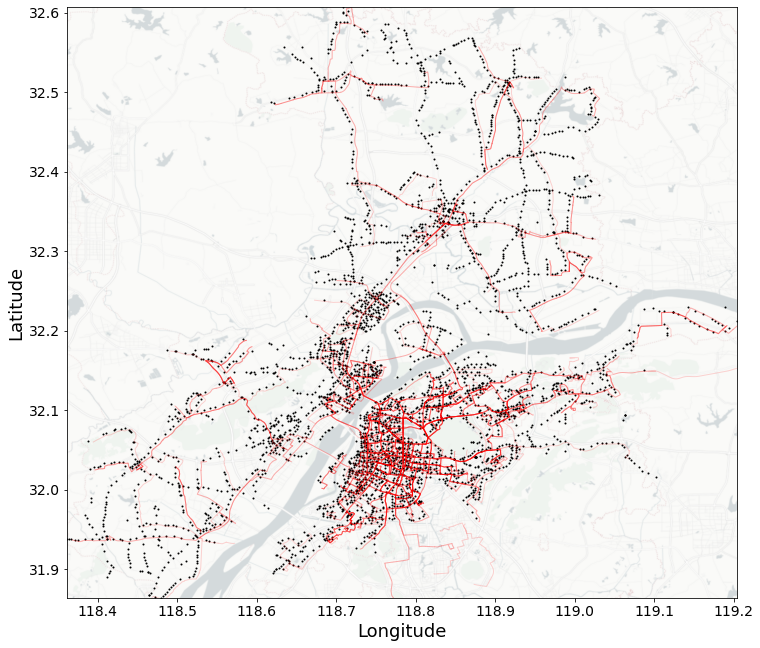

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,16))
stop_ls_layer.plot(ax=ax,color='black', markersize=1,rasterized=True)
route_filtered.plot(ax=ax, color='red', linewidths=1, alpha=0.1618)
style = "light_nolabels"
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png' % style
# Add basemap with `OSM_A` style using zoom level of 14
ctx.add_basemap(ax, zoom=11, attribution="", crs=route_filtered.crs.to_string(), source=cartodb_url)

ax.set_ylim(df_nodes.lat.min(), df_nodes.lat.max())
ax.set_xlim(df_nodes.long.min(), df_nodes.long.max())
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
fig.savefig('./tmp_results/nanjing_bus_route_v2.svg',dpi=200)

#### 2.4 Visualization (bus stops from Gaode)

In [28]:
# No need to convert from gcj02 to wgs84, it has already been converted.
df_nodes = pd.read_csv('./data/nanjing_station_GD.csv')
# df_nodes = df_nodes[df_nodes.line_name.isin(all_buslines.line_name)]

In [29]:
stop_ls_layer = gpd.GeoDataFrame(
    df_nodes, geometry=gpd.points_from_xy(df_nodes.coord_x, df_nodes.coord_y))
stop_ls_layer.crs = CRS.from_epsg(4326).to_wkt()
stop_ls_layer.set_index('station_name', inplace=True)

In [30]:
stop_ls_layer.to_file('stops.shp')

C:\Users\LENOVO~1\AppData\Local\Temp/ipykernel_21040/815287991.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  stop_ls_layer.to_file('stops.shp')


In [8]:
all_buslines.polyname = all_buslines.polyname.apply(lambda x: ast.literal_eval(x))

In [10]:
len(df_nodes)

13113

In [14]:
%%time
for index, row in all_buslines.iterrows():
    each_poi_list = []
    for each_poi in row.polyname:
        each_poi_list.append(ctf.gcj02_to_wgs84(each_poi[0],each_poi[1]))
    all_buslines.at[index, 'polyname'] = each_poi_list

Wall time: 1.46 s


In [16]:
all_buslines.polyname = all_buslines.polyname.apply(lambda x: LineString(x))
all_buslines = all_buslines.rename(columns = {'polyname':'geometry'})
route_filtered = gpd.GeoDataFrame(all_buslines, geometry='geometry')
route_filtered.crs = CRS.from_epsg(4326).to_wkt() # G

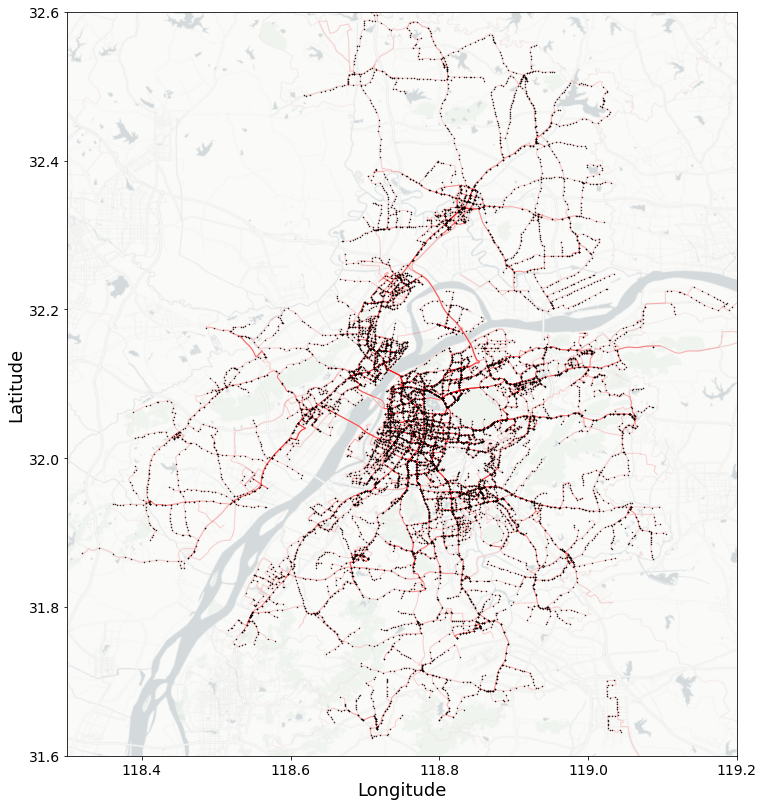

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,16))
stop_ls_layer.plot(ax=ax,color='black', marker = '.', markersize=0.8, zorder = 10, rasterized=True)
route_filtered.plot(ax=ax, color='red', linewidths=1, alpha=0.1618, zorder = 5)
style = "light_nolabels"
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png' % style
# Add basemap with `OSM_A` style using zoom level of 14
ctx.add_basemap(ax, zoom=11, attribution="", crs=route_filtered.crs.to_string(), source=cartodb_url)

ax.set_ylim(31.6, 32.6)
ax.set_xlim(118.3, 119.2)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
fig.savefig('./tmp_results/nanjing_bus_route.svg',dpi=100)